# Introduction to Variational Autoencoders


Variational Autoencoders are a type of network that seeks to represent (encode) an input into a low-dimensional latent space and reconstruct (decode) it back.

Traditional autoencoders map an input to a latent space and decode it back to an ouput with the same dimensions as the input. The name of the game is then to minimize the distance between the input and output, using mean squared error as a distance metric. It turns out that an autoencoder, as is, will typically lead to sparse latent spaces with poor continuity. 

The fundamental idea of variational autoencoders is to map an input onto a probability distribution, from which is sampled a point to decode back. This enforces continuity in the latent space as every point sampled in the latent space is mapped to a valid output.  

This continuity allows us to use **concept vectors**, **interpolation**, and **latent space exploration**  for content editing and generation.

Code and content for this notebook, taken from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python), by François Chollet and this [colab](https://colab.research.google.com/drive/1a4fBqFBa9FxhKxGr9rlUVWktU5hH5nUy#scrollTo=r0JsN0RX2X-Q). 

---

This example uses the Keras functional API (rather than Sequential) to define a variational autoencoder and apply it on the MNIST dataset to generate a latent space of handwritten digits. 



### Step 1. Import libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


### Step 2. Configure VAE Encoder Network

In [ ]:
latent_dim = 2 # dimensionality of latent space

# we are starting with something that very much looks like a typical CNN
encoder_inputs = keras.Input(shape=(28, 28, 1)) # takes in a 28 x 28 image, with a single black/white channel
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# the input image ends up being encoded in these two parameters
z_mean = layers.Dense(latent_dim, name="z_mean")(x)         # mean
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)   # variance

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")  # this is our first model
                                                                            # takes image input and outputs mean and variance in latent space

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

### Step 3. Use mean and variance to generate a latent space coordinates

In [ ]:
# latent-space sampling layer

import tensorflow as tf

class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]                          
    z_size = tf.shape(z_mean)[1]                              
    epsilon = tf.random.normal(shape=(batch_size, z_size))    
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon     # Apply the VAE sampling formula


### Step 4. Configure VAE Decoder Network

In [ ]:

latent_inputs = keras.Input(shape=(latent_dim,))    # this is the input 

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) # 7*7*64=3136  it's the same number of coefficients we had at the level of Flatten layer in encoder
x = layers.Reshape((7, 7, 64))(x)   # Revert the flatten layer of the encoder
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # Revert the Conv2D layers. This is a reverse convolution.
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)  # The output ends with a shape (28, 28, 1), which is where encoder started
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

### Step 5. Create the VAE model with a custom train_step()

We need to create a new kind of training because we are deviating from the classic supervised learning model, and instead doing self-supervised (where the input is used as target). 

In [ ]:


# Whenever you depart from classic supervised learning, it’s common to subclass the Model class and implement a custom train_ step()
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs): # explanation of kwargs https://realpython.com/python-kwargs-and-args/
    super().__init__(**kwargs)  # super() for inheriting from keras.Model super class https://realpython.com/python-super/
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()

    # we use these metrics to keep track of the loss averages over each epoch
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")   
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property                  # how to use property decorator: https://www.programiz.com/python-programming/property
  def metrics(self):         # we list the metrics here in the metrics property to emable the model to reset them after each epoch            
    return [self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]

  def train_step(self, data):
      with tf.GradientTape() as tape:           # Python 'with' used here to ensure proper release of resource
        z_mean, z_log_var = self.encoder(data)  # get z_mean (mean) and z_log_var (variance) from data input into encoder
        z = self.sampler(z_mean, z_log_var)     # use the VAE sampling formula to get z
        reconstruction = decoder(z)             # pass z to decoder
        reconstruction_loss = tf.reduce_mean(   # We sum the reconstruction loss over the spatial dimensions (axes 1 and 2) and take its mean over the batch dimension. 
            tf.reduce_sum(                      
                keras.losses.binary_crossentropy(data, reconstruction),   # input tensor to sum function. computes loss.
                axis=(1, 2)
            )
        )
        # add the regularization term (Kullback-Leibler divergence) https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))      # zip aggregates iterables in a tuple
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss":  self.kl_loss_tracker.result(),
        }


### Step 6. Loading the Data and Training the VAE

In [ ]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()  # by using underscore we ignore what would typically have been y_train and y_test
mnist_digits = np.concatenate([x_train, x_test], axis=0)      # we train on all MNIST digits, so concatenate training and test samples
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")/255   # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html


vae = VAE(encoder, decoder)   # initialize network
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)  # we don't pass a loss argument to compile, since the loss is already part of train_step()
vae.fit(mnist_digits, epochs=30, batch_size=128)   # we don't pass targets in fit(), since train_step() doesn't expect any



11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 28s 33ms/step - total_loss: 210.0824 - reconstruction_loss: 207.6667 - kl_loss: 2.4157
Epoch 2/30
547/547 [==============================] - 18s 33ms/step - total_loss: 183.1990 - reconstruction_loss: 180.5258 - kl_loss: 2.6730
Epoch 3/30
547/547 [==============================] - 18s 33ms/step - total_loss: 166.0945 - reconstruction_loss: 162.4095 - kl_loss: 3.6849
Epoch 4/30
547/547 [==============================] - 18s 32ms/step - total_loss: 161.2875 - reconstruction_loss: 157.5639 - kl_loss: 3.7237
Epoch 5/30
547/547 [==============================] - 18s 33ms/step - total_loss: 158.5291 - reconstruction_loss: 154.7598 - kl_loss: 3.7694
Epoch 6/30
547/547 [==============================] - 18s 33ms/step - total_loss: 156.5824 - reconstruction_loss: 152.7709 - kl_loss: 3.8113
Epoch 7/30
547/547 [==============================] - 18s 33ms/step - total_loss: 155.300

### Step 7. Sample of grid of images from the 2D latent space


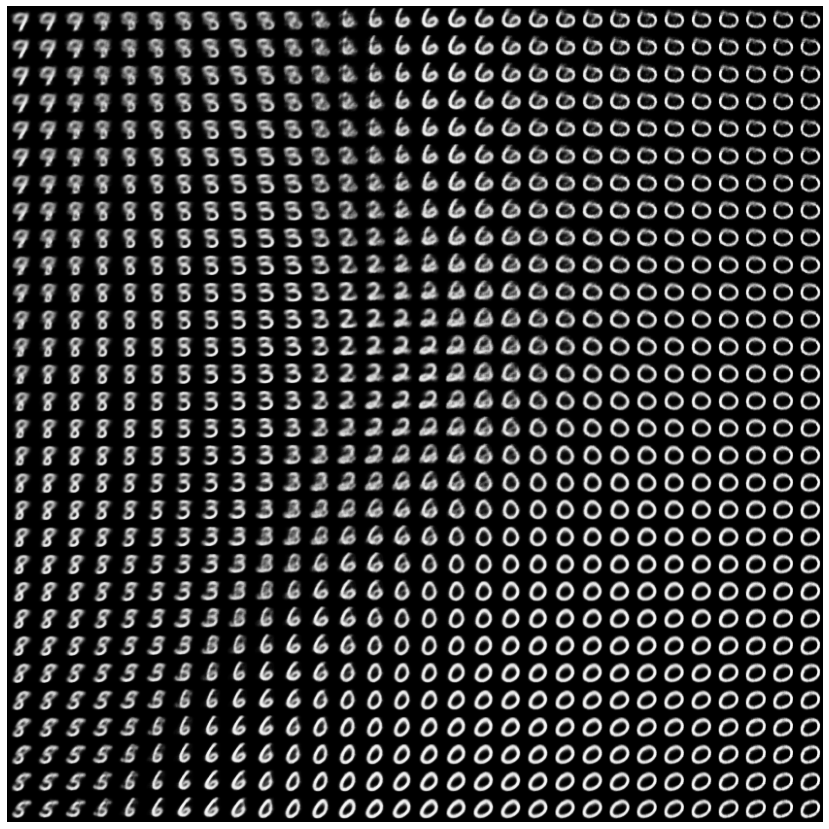

In [ ]:
from numpy.lib.function_base import digitize
import matplotlib.pyplot as plt

n = 30  # display a grid of 30x30 images, so 900 images total
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)          # returns interval between -1 and 1, in 30 steps
grid_y = np.linspace(-1, 1, n)[::-1]    # same, backwards. 

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):    #iterate over grid locations

    # for each location, sample a digit and add it to our figure
    z_sample = np.array([[xi,yi]])  
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[
           i * digit_size : (i + 1) * digit_size,
           j * digit_size : (j + 1) * digit_size,
           ] = digit

# Go plot all the images in a grid
plt.figure(figsize=(15,15))
start_range = digit_size // 2   # ?? //
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size) # https://numpy.org/doc/stable/reference/generated/numpy.arange.html
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")


### 8. Other Useful Code Snippets


[[-0.57 -0.5 ]]


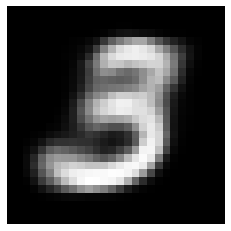

In [ ]:
# Generate a single image
xpos = -0.57 # from - 1 to 1
ypos = -0.5
seed = np.array([[xpos,ypos]])
print(seed)

generatedImage = vae.decoder.predict(seed)
generatedImage = generatedImage.reshape(28,28)
plt.axis("off")
plt.imshow(generatedImage, cmap="Greys_r")


In [ ]:
# Save model
model = vae.decoder
model.save('/content/vaemodel')


INFO:tensorflow:Assets written to: /content/vaemodel/assets


[[-0.57 -0.5 ]]


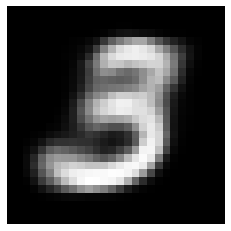

In [ ]:
#Reload saved model
new_model = keras.models.load_model('/content/vaemodel')

# Generate image from saved model
xpos = -0.57 # from - 1 to 1
ypos = -0.5
seed = np.array([[xpos,ypos]])
print(seed)

generatedImage = new_model.predict(seed)
generatedImage = generatedImage.reshape(28,28)
plt.axis("off")
plt.imshow(generatedImage, cmap="Greys_r")
